
# Customer Churn Prediction – EDA & Modeling

This notebook performs exploratory data analysis (EDA), feature engineering, model training, and evaluation for the **Customer Churn Prediction** project.  
It uses **Scikit-learn**, **XGBoost**, and **SHAP** (optional) and is designed to work with the Telco Customer Churn dataset.


In [2]:

# --- Imports & Configuration ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib

# Try to import shap (optional for explainability)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

plt.rcParams['figure.figsize'] = (8, 5)

# Path to data relative to this notebook (assuming repo layout)
DATA_PATH = '../data/telco_churn.csv'  # <-- change if different
ARTIFACT_DIR = '../artifacts'
os.makedirs(ARTIFACT_DIR, exist_ok=True)

print('SHAP available:', SHAP_AVAILABLE)
print('Data path:', DATA_PATH)


SHAP available: True
Data path: ../data/telco_churn.csv


## 1. Load & Preview Data

In [3]:

# --- Load & Preview ---
df = pd.read_csv(DATA_PATH)

# Clean up TotalCharges if present (coerce to numeric)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print('Shape:', df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Basic EDA

Churn
No     5174
Yes    1869
Name: count, dtype: int64


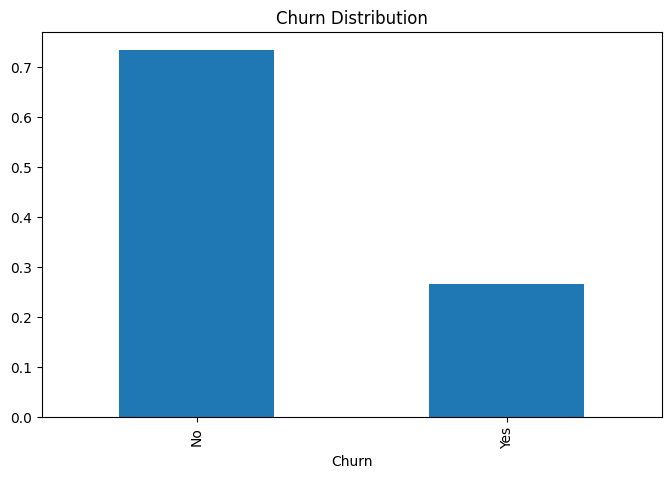

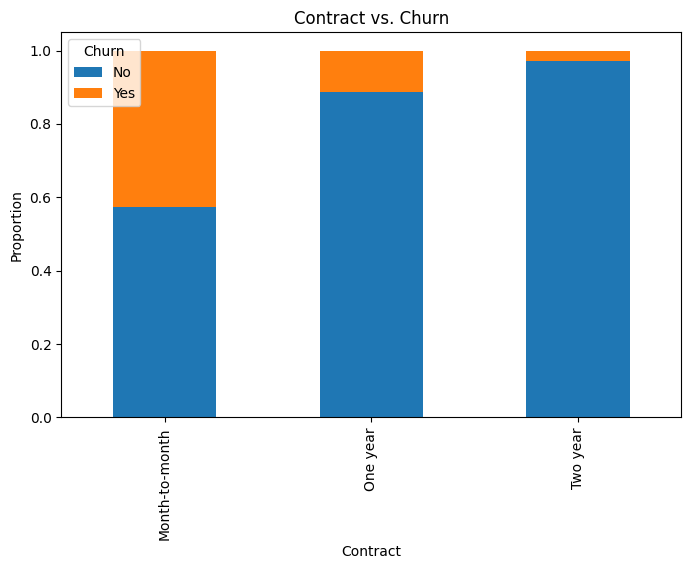

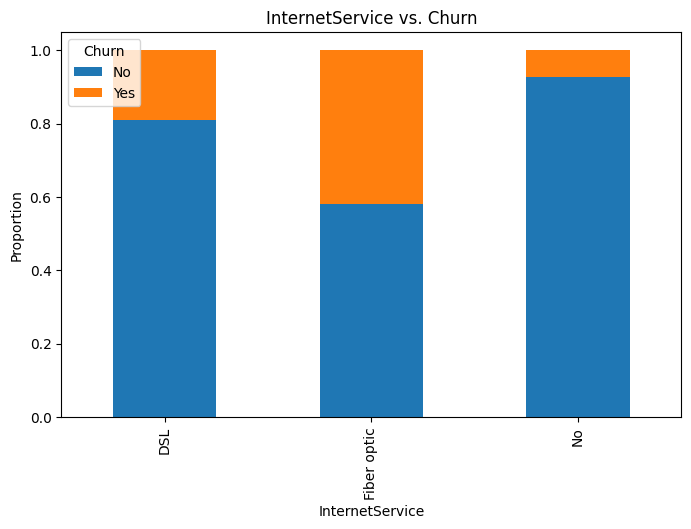

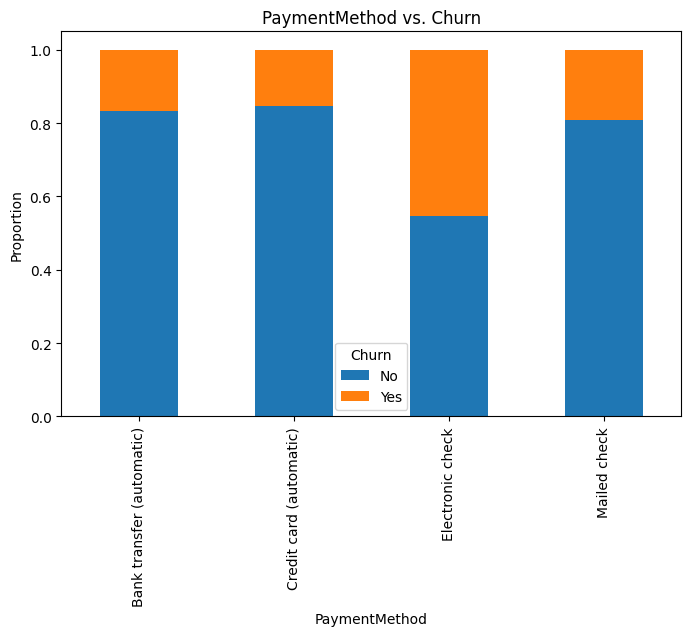

In [4]:

# Target distribution
target_col = 'Churn'  # assumes Yes/No
if target_col in df.columns:
    print(df[target_col].value_counts(dropna=False))
    df[target_col].value_counts(normalize=True).plot(kind='bar', title='Churn Distribution'); plt.show()

# Example relationships (customize as needed)
for col in ['Contract', 'InternetService', 'PaymentMethod']:
    if col in df.columns and target_col in df.columns:
        ct = pd.crosstab(df[col], df[target_col], normalize='index')
        ct.plot(kind='bar', stacked=True, title=f'{col} vs. Churn'); plt.ylabel('Proportion'); plt.show()


## 3. Train/Test Split & Preprocessing

In [5]:

# --- Split X, y ---
y = (df[target_col].astype(str).str.lower() == 'yes').astype(int)
X = df.drop(columns=[target_col])

# Identify dtypes
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Preprocessor: impute, scale numeric; one-hot encode categoricals
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape


((5634, 20), (1409, 20))

## 4. Baseline Models & Cross-Validation

In [6]:

# Define candidate models
models = {
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    'xgb': XGBClassifier(
        n_estimators=500, eval_metric='auc', tree_method='hist', n_jobs=-1, random_state=42
    )
}

cv_results = {}
for name, clf in models.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    scores = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
    cv_results[name] = (scores.mean(), scores.std())
    print(f'{name}: ROC-AUC {scores.mean():.3f} ± {scores.std():.3f}')

cv_results


logreg: ROC-AUC 0.846 ± 0.014
rf: ROC-AUC 0.834 ± 0.014
xgb: ROC-AUC 0.808 ± 0.007


{'logreg': (np.float64(0.8456947918571416), np.float64(0.01398433800430946)),
 'rf': (np.float64(0.8338053202236523), np.float64(0.014096514049514288)),
 'xgb': (np.float64(0.8079149543976988), np.float64(0.007388764145710784))}

## 5. Hyperparameter Tuning (XGBoost)

In [7]:

param_grid = {
    'clf__max_depth': [4, 6, 8],
    'clf__learning_rate': [0.03, 0.1],
    'clf__subsample': [0.8, 1.0]
}

xgb_pipe = Pipeline([('prep', preprocessor),
                     ('clf', XGBClassifier(n_estimators=500, eval_metric='auc', tree_method='hist', n_jobs=-1, random_state=42))])

gs = GridSearchCV(xgb_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print('Best params:', gs.best_params_)
print('Best CV ROC-AUC:', gs.best_score_)

best_model = gs.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__learning_rate': 0.03, 'clf__max_depth': 4, 'clf__subsample': 0.8}
Best CV ROC-AUC: 0.8454396129493144


## 6. Evaluation on Holdout Set

Holdout ROC-AUC: 0.842

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



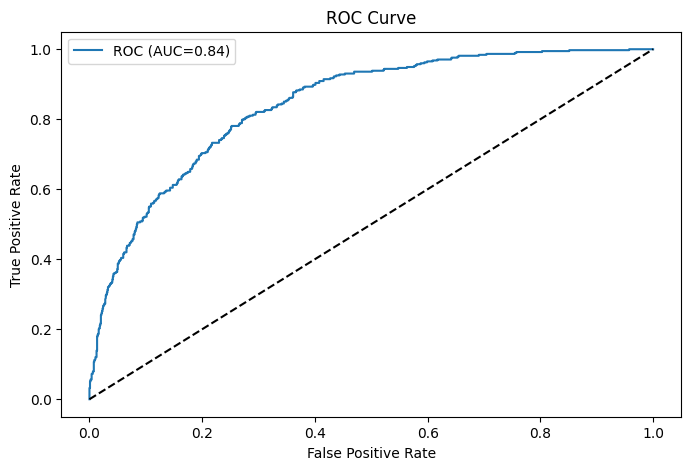

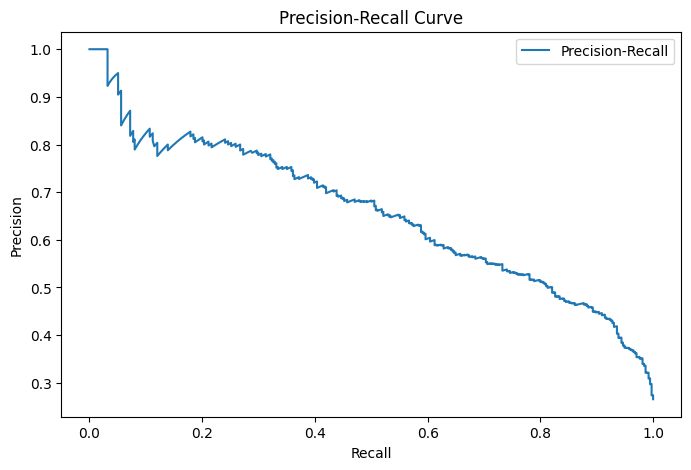

In [8]:

y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
print('Holdout ROC-AUC:', round(auc, 3))
print('\nClassification Report\n', classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec, label='Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


## 7. Explainability (SHAP)

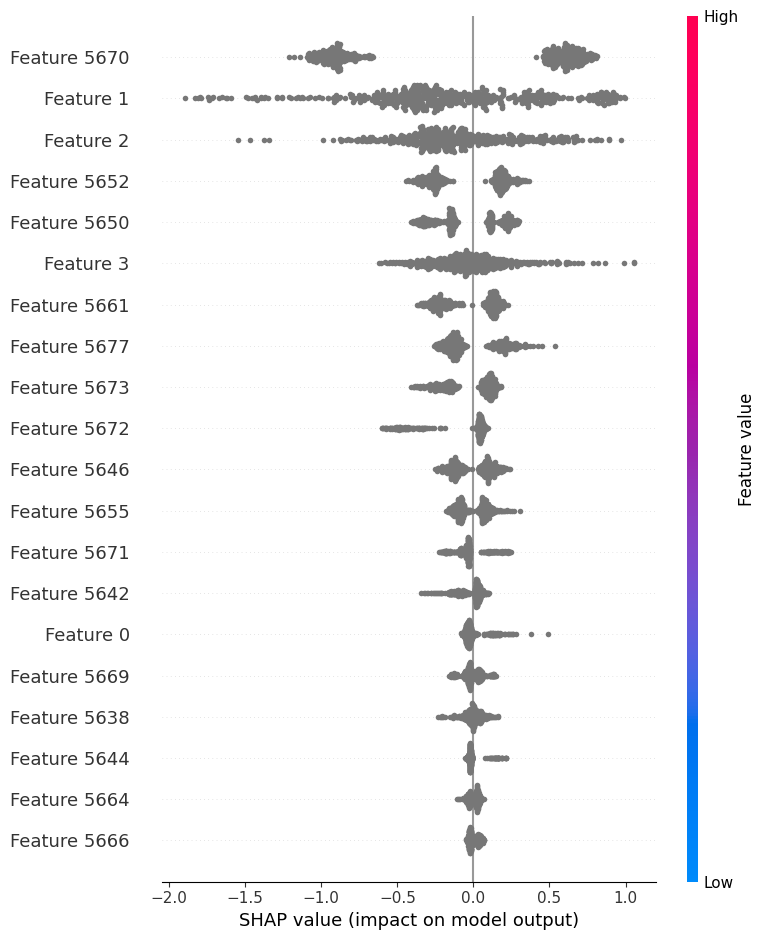

In [9]:

if SHAP_AVAILABLE:
    # Take a small sample to speed up plotting if needed
    X_sample = X_test.sample(min(500, len(X_test)), random_state=42)
    # Extract the underlying trained XGB model after preprocessing
    # We can transform X_sample with the preprocessor to a numeric matrix
    X_mat = best_model.named_steps['prep'].transform(X_sample)
    xgb_clf = best_model.named_steps['clf']

    explainer = shap.TreeExplainer(xgb_clf)
    shap_values = explainer.shap_values(X_mat)

    shap.summary_plot(shap_values, X_mat, show=True)
else:
    print("SHAP not installed. To enable, install shap and rerun this cell.")


## 8. Save Trained Model

In [10]:

model_path = os.path.join(ARTIFACT_DIR, 'xgb_nb_model.joblib')
joblib.dump(best_model, model_path)
model_path


'../artifacts\\xgb_nb_model.joblib'